## Imports

In [1]:
import numpy as np # For matrix/vector operations
import gzip        # For un-zipping the MNIST data
import pickle      # For de-serializing the MNIST data
import matplotlib.pyplot as pyplot # For graphing

## Import MNIST Data

In [2]:
"""
We use the serialized and zipped copy of the MNIST data available at Michael Nielson's 
repository:
https://github.com/mnielsen/neural-networks-and-deep-learning
"""
# Unzip the MNIST Data
with gzip.open('mnist.pkl.gz', 'rb') as f:
    # Unpickle (de-serialize) the
    mnist_data = pickle.load(f, encoding='bytes');
    
"""
mnist_data = 3-tuple containing (mnist_training, mnist_validation, mnist_testing)
    mnist_training = 2-tuple containing (training_data, training_labels)
        training_data = [50,000, 784] ndarray of data for each training example
        training_labels = [50,000] ndarray of labels for the training_data
    mnist_validation = 2-tuple containing (validation_data, validation_labels)
        validation_data = [10,000, 784] ndarray of data for each validation image
        validation_labels = [10,000] ndarray of labels for the training_data
    mnist_testing = 2-tuple containing (testing_data, testing_labels)
        testing_data = [10,000, 784] ndarray of data for each testing image
        testing_labels = [10,000] ndarray of labels for testing data
"""    
training_data = mnist_data[0][0];
training_labels = mnist_data[0][1];
validation_data = mnist_data[1][0];
validation_labels = mnist_data[1][1];
testing_data = mnist_data[2][0];
testing_labels = mnist_data[2][1];
# Concatenate lables to end of each training example to work with the implementation
# of the train() function
# Now training_examples, validation_examples, and testing_examples are all 
# [50,000, 785] or [10,000, 785] arrays where the last column contains the labels
training_examples = np.column_stack((training_data, training_labels));
validation_examples = np.column_stack((validation_data, validation_labels));
testing_examples = np.column_stack((testing_data, testing_labels));

## Network Class

In [3]:
"""
Simple_NN
Class to create a simple neural network
    Learning Algorithm: stochastic gradient descent with backpropagation
    Activation Function: sigmoid
    Cost Function: MSE
"""
class Simple_NN(object):
    """ 
    INITIALIZE THE NETWORK
    """
    def __init__(self, layers, activation_function="sigmoid", cost_function="MSE"):
        """
        self.layers is a list of numbers where the ith number how many neurons are in
        the ith layer of the network.
        """
        self.layers = layers;
        self.num_layers = len(layers);
        
        """
        self.weights[Layer - 1, input_neuron, output_neuron] = 
                                            List of weight matrices for each layer.                      
        self.biases[Layer - 1, neuron] = 
                                            List of vectors with biases for each neuron  
        FOR EXAMPLE:
            self.weights[layer, j, i] = weight going into the jth neuron of the lth layer
                                    from the ith neuron of the (l-1)st layer 
            self.biases[layer, k] = bias on the kth nuron of the lth layer
        NOTE: layer 0 is the input layer, so self.weights[0] is the weights going into layer 1
        """
        self.weights = [];
        self.biases = [];
        self.Z = [];
        self.activations = [];
        # Create matrices with correct dimensions 
        for layer_num in range(1, self.num_layers):
            self.weights.append(np.random.randn(layers[layer_num], layers[layer_num - 1]));
            self.biases.append(np.random.randn(layers[layer_num]));
        """
        self.activation = string specifying what activation function the neurons will use. 
            The options are:
            sigmoid (default)
        self.cost_function = string specifying hat cost function will be used for the 
            network.
            The options are:
            MSE (default)
        """
        self.activation_function = activation_function;
        self.cost_function = cost_function;
        self.errors = [];
        self.gradC_b = [];
        self.gradC_w = [];
 
    """
    TRAINING
    Train the network using stochastic gradient descent and backpropagation.
    Training data should be given in the following format:
        [x11, x12, ..., x1i, y1
         x21, x22, ..., x2i, y2
         ...
         xm1, xm1, ..., xmi, ym]
    Where each row corrsponds to a training example with i data points
    """
    def train(self, training_data, testing_data, batch_size, num_epochs, learning_rate):
        for epoch in range(num_epochs):
            # Randomize the order of training examples
            np.random.shuffle(training_data);
            # Separate inputs from outputs
            inputs = training_data[:, :-1];
            outputs = training_data[:, -1];
            testing_inputs = testing_data[:, :-1];
            testing_labels = testing_data[:, -1];
            # For each epoch, loop through each batch to use as training data
            for batch in range(len(training_data))[::batch_size]:
                """
                For each batch, we calculate activations and use the backpropagation
                algorithm to change the weights and biases using gradient descent
                Create matrix out of all training inputs in the batch
                To apply W to all input vectors, we can multiply WX where
                X is the ixm matrix containing all m training examples as columns
                """
                X = inputs[batch : batch + batch_size];
                Y = outputs[batch : batch + batch_size];
                X = np.transpose(X);
                # FEEDFORWARD
                self.evaluate(X, training=True);
                # BACKPROPAGATION
                self.backpropagate(X, Y);
                # GRADIENT DESCENT
                self.grad_descent();
            # For each epoch, compute number of correct outputs out of testing data
            print("Epoch %d: %s" % \
                  ((epoch + 1), self.test(testing_inputs, testing_labels)));
    """
    EVALUATE
    Takes an input column vector X and computes the output of the network
    """
    def evaluate(self, X, training=False):
        """
        self.Z[layer, neuron, training_example] = 
                        List of vectors with weighted inputs to the neurons
        self.activations[layer, neuron, training_Example] = 
                        List of vectors with activations for each neuron
        """
        self.Z = [];
        self.activations = [];
        # Calclate outputs going forwards through the network
        for layer in range(self.num_layers - 1):
            if layer == 0:
                # Feed inputs to the network
                prev_activations = X;
            else:
                prev_activations = self.activations[layer - 1];
            # If training, X will be a 2D matrix [input, training_example]. In this case,
            # bias_matrix where each column is a copy of the bias vector is needed
            # to add bias terms for each training example.
            if (training):
                one_vector = np.ones(np.shape(X)[1]);
                bias_matrix = np.outer(self.biases[layer], one_vector);
            else:
                # When evaluating single training example, we want a 1D bias vector
                bias_matrix = self.biases[layer];
            self.Z.append(np.dot(self.weights[layer], prev_activations) + bias_matrix);
            self.activations.append(self.activation(self.Z[layer]));
        
    """
    BACKPROPAGATE
    Using input vector X and output vector Y, calculates the following instance variables:
        self.errors[layer, neuron, training_example] - error in each neuron
        self.gradC_b[layer] - average gradient wrt biases over all training examples
        self.gradC_w[layer, input_neuron, output_neuron] - average gradient wrt weights
    """
    def backpropagate(self, X, Y):
        # Calculate output error matrix so the [i, j]th entry contains the
        # error for the ith neuron in the output layer for the jth training
        # example
        output_error = np.multiply(
                             self.cost_derivative(self.activations[-1], Y),
                             self.activation_derivative(self.Z[-1]));
        # Backpropogate: we create the errors matrix which is indexed
        # in the form errors[layer, neuron, training_example]
        self.errors = [output_error];
        # Note that in the loop, we use negative subscripts to go through the 
        # layers from output towards input. We therefore start at layer [-2], the
        # second to last layer
        for layer in range(2, self.num_layers):               
            # For each layer, calculate errors in previous layer
            previous_errors = np.multiply(
                                np.dot(
                                    np.transpose(self.weights[-layer + 1]),
                                    self.errors[0]), 
                                self.activation_derivative(self.Z[-layer])); 
            # Add previous errors to the beginning of the error matrix list
            self.errors.insert(0, previous_errors);
        # Calculate gradients of cost function
        self.gradC_b = [];
        self.gradC_w = [];
        for layer in range(self.num_layers - 1):
            """
            gradC_b[layer, neuron] = 
            Gradient of cost wrt biases for a layer is just the
            vector of errors for that layer.
            When we compute the average over all training examples using 
            np.average(matrix, 1), we get a column vector. In order to
            correctly subtract this from the row-vector of biases, 
            we transpose the gradient vectors.
            """
            self.gradC_b.append(np.average(self.errors[layer],1));
            """
            sum_of_weights[layer, j, k] will contain the partial derivative 
            of cost wrt the weight from the kth neuron in layer - 1 to the jth
            neuron in layer summed over all training examples. That is,
            sum_of_weightes[layer, j, k] = [sum over training examples dC/dw_j,k]
            """
            if (layer == 0):
               prev_activations = X;
            else:
               prev_activations = self.activations[layer - 1];
            sum_of_weights = np.dot(
                                    self.errors[layer],
                                    np.transpose(prev_activations));
            """
            gradC_w [layer, input_neuron, output_neuron] is also 
                averaged over all traininge examples in the batch
            """
            self.gradC_w.append((1 / batch_size) * sum_of_weights);
    
    """
    GRADIENT DESCENT
    Use the gradients computed in backpropagate() to update the weights and
    biases of the network.
    """
    def grad_descent(self):
        for layer in range(self.num_layers - 1):
            self.biases[layer] = np.subtract(self.biases[layer],
                        np.transpose(np.multiply(learning_rate, self.gradC_b[layer])));
            self.weights[layer] = np.subtract(self.weights[layer],
                        np.multiply(learning_rate, self.gradC_w[layer]));
        
    """ 
    ACTIVATION FUNCTION
    For this network, we use the sigmoid function to calculate neuron activation
    In general, we assume the input z will be a matrix where the [i,j]th entry is the
    ith neuron in the jth training example
    """      
    def activation(self, z):
        if (self.activation_function == "sigmoid"):
            return 1.0 / (1 + np.exp(-z));
    
    def activation_derivative(self, z):
        if (self.activation_function == "sigmoid"):
            return np.multiply((1 - self.activation(z)), self.activation(z));
    """
    COST FUNCTION
    We assume that activations is a 2D matrix where each column corresponds to the activations
    for a specific training example and each row corresponds to a specific neuron

    We assume for now that outputs for the network are disjoint categories, so only
    one output neuron should fire at a time. The output_matrix function turns the output
    vector where each entry corresponds to a training example into a matrix where each
    column corresponds to a training example, with only one nonzero entry per column
    corresponding to the output for that example
    
    Both calculate_cost and cost_derivative return a row vector where the ith entry
    is the cost/cost derivative for training example i
    """
    def output_matrix(self, activations, outputs):
        # output_matrix[neuron, training_example]
        output_matrix = np.zeros((activations.shape[0], outputs.shape[0]));        
        for training_example, output in enumerate(outputs): 
            output_matrix[int(output), training_example] = 1;
        return output_matrix;

    def calculate_cost(self, activations, outputs):
        outputs_matrix = self.output_matrix(activations, outputs);
        if (self.cost_function == "MSE"):
            squared_errors = np.square(activations - output_matrix);
            # Average sum of squared errors over each training example
            return 0.5 * np.average(np.sum(squared_errors, 0));
    """
    Derivative of cost functions with respect to activations
    Each entry [i, j] in the resulting matrix will be the gradient of the cost function
    with respect to the activation of the ith neuron in the jth training example
    """
    def cost_derivative(self, activations, outputs):
        output_matrix = self.output_matrix(activations, outputs);
        if (self.cost_function == "MSE"):
            return (activations - output_matrix);
        
    """
    PREDICT
    predict(x) - Given a data vector x, returns an integer for which class the network 
        predicts x belongs to. That is, the integer returned is the neuron in the 
        output layer with the maximum activation, indexed starting at 0.
    """
    def predict(self, x):
        self.evaluate(x);
        return np.argmax(self.activations[-1]);
      
    """
    display_prediction(x) shows an image of the input with the network prediction.
        Height and width can be customized, but their defualts are set for the MNIST images.
        The show parameter also allows you to not immediately show the prediction, allowing
        for subplotting.
    """
    def display_prediction(self, x, height=28, width=28, show=True):
        prediction = self.predict(x);
        image = np.reshape(x, (height,width));
        pyplot.title('Prediction: %d' % prediction, fontsize = 12, color = 'white');
        pyplot.imshow(image, cmap='Greys_r');
        if (show):
            pyplot.show();
            
    """
    display_predictions(index) will create a figure with 9 images and their predicted
        digits. The images are selected from the testing images beginning with the image
        with the given index. Indices must be between 0-10,000
    """
    def display_predictions(self, index):
        for example_num in range(1, 10):
            subplot = 330 + example_num;
            pyplot.subplot(subplot);
            test.display_prediction(testing_data[index + example_num], show=False);
            pyplot.axis('off'); 
        pyplot.tight_layout();
        pyplot.show();
    
    """
    test(testing_data, testing_labels) - predicts class for all data in 
        testing_data and computes accuracy as a percentage using 
    """
    def test(self, testing_data, testing_labels):
        total_examples = len(testing_labels);
        total_correct = 0;
        for example in range(total_examples):
            if (testing_labels[example] == self.predict(testing_data[example])):
                total_correct = total_correct + 1;
        accuracy = total_correct / total_examples;
        return (str(total_correct) + " / " + str(total_examples) + " = " + str(accuracy))

    """
    print_network prints the weights, biases, and activations for the entire network. 
        An argument of 1 enables debugging mode, which prints more information, 
        including errors and gradients.
    """
    def print_network(self, debug=0):
        print("Number of layers: ");
        print(self.num_layers);
        print("Weights: ")
        for layer in self.weights:
            print(layer)
        print("\nBiases:" )
        for layer in self.biases:
            print(layer)
        print("\nActivations:")
        for layer in self.activations:
            print(layer);
        # Print extra info about the network
        if (debug == 1):
            print("\nWeighted Inputs:")
            for layer in self.Z:
                print(layer)
            print("\nErrors:")
            for layer in self.errors:
                print(layer)
            print("\nBias Gradients:")
            for layer in self.gradC_b:
                print(layer)
            print("\nWeight Gradients")
            for layer in self.gradC_w:
                print(layer)
    """
    print_activations will print the output activations
    """
    def print_activations(self, index=0):
        image = testing_data[index];
        test.predict(image);
        print("Output Activations:")
        for i in range(0, 10):
            print("%d: %f" % (i, test.activations[1][i]))

In [4]:
"""
CREATE AND TRAIN NETWORK
"""
test = Simple_NN([784, 30, 10]);
    
batch_size = 10;
num_epochs = 5;
learning_rate = 3;

test.train(training_examples, validation_examples, batch_size, num_epochs, learning_rate);
print("Done Training")

Epoch 1: 9166 / 10000 = 0.9166
Epoch 2: 9286 / 10000 = 0.9286
Epoch 3: 9391 / 10000 = 0.9391
Epoch 4: 9414 / 10000 = 0.9414
Epoch 5: 9456 / 10000 = 0.9456
Done Training


In [5]:
"""
TEST NETWORK
"""
result = test.test(testing_data, testing_labels);
print(result)

9380 / 10000 = 0.938


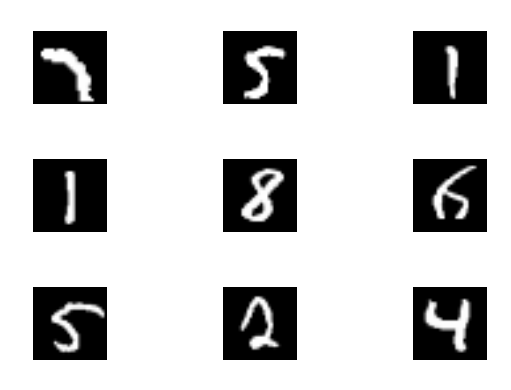

In [6]:
"""
VISUALIZE RESULTS
"""
index =1670;
test.display_predictions(index);